In [1]:
import os
import time
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import gridspec
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim

In [2]:
device: torch.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
epoch_number: int = 51
latent_dimension: int = 100
batch_size: int = 32
embed_dimension: int = 50
one_hot_label: bool = False
label_smooth_fac: float = 0.9
decay_discrim_lr: bool  = True
learning_rate_discriminator: float = 0.0002
learning_rate_generator: float = 0.0002
checkpoint_path: str = os.path.join('model_checkpoint', 'mnist_data')
img_height: int = 28
img_width: int = 28
num_channels: int = 1

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5), std = (0.5))
])

dataset_train = datasets.MNIST(
    root = 'data',
    train = True,
    download = True,
    transform = transform
)

In [4]:
train_dataloader = DataLoader(
    dataset = dataset_train,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 4
)

In [5]:
label_dict = {
    0: 'Zero',
    1: 'One',
    2: 'Two',
    3: 'Three',
    4: 'Four',
    5: 'Five',
    6: 'Six',
    7: 'Seven',
    8: 'Eight',
    9: 'Nine',   
}

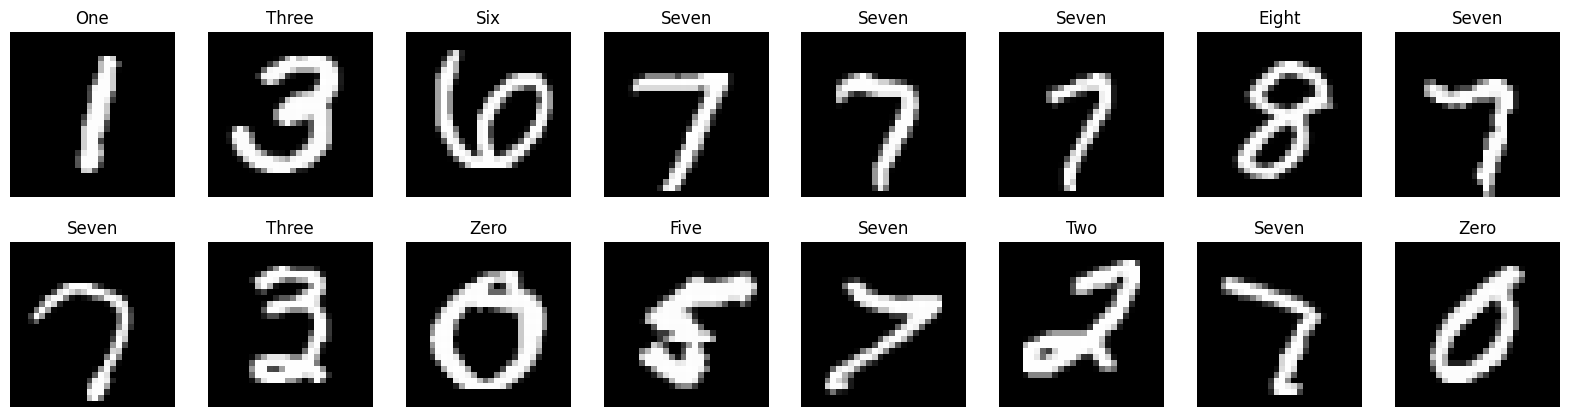

In [6]:
plt.figure(figsize = (20, 5))

for i, (image, label)  in enumerate(train_dataloader):
    if i == 8:
        break
    nrow = 2
    ncol = min(8, int(batch_size / nrow))

    for i in range(nrow * ncol):
        ax = plt.subplot(nrow, ncol, i + 1)
        plt.title(label_dict[int(label[i])])
        plt.imshow(np.squeeze(image[i].permute(1, 2, 0), axis = 2), cmap = 'gray')
        plt.axis("off")
    break

In [7]:
class Generator(nn.Module):
    def __init__(self, num_classes):
        super(Generator, self).__init__()
        if one_hot_label:
            self.label = F.one_hot(tensor = torch.tensor(input_label), num_classes = num_classes)
            self.n_nodes = 7 * 7
            self.label_info = nn.Linear(50, self.n_nodes)
        else:
            self.label = nn.Embedding(num_classes, embed_dimension)
            self.n_nodes = 7 * 7
            self.label_info = nn.Linear(embed_dimension, self.n_nodes)
        self.n_nodes_out = 7 * 7 * 128
        self.latent_out = nn.Sequential(nn.Linear(latent_dimension, self.n_nodes_out), nn.LeakyReLU())
        torch.nn.init.xavier_uniform_(self.latent_out[0].weight)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(129, 128, 4, 2, bias = False),
            nn.BatchNorm2d(128, momentum = 0.1, eps = 0.8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 128, 4, 2, bias=False),
            nn.BatchNorm2d(128, momentum = 0.1, eps = 0.8),
            nn.ReLU(True), 
            
            nn.Conv2d(128, num_channels, 7, stride = 1, bias = False),
            nn.Tanh()
        )
        torch.nn.init.xavier_uniform_(self.model[0].weight)
    
    def forward(self, inputs):
        noise_vector, labels = inputs
        label_out = self.label(labels)
        label_out = self.label_info(label_out)
        label_out = label_out.view(-1, 1, 7, 7)
        latent_out = self.latent_out(noise_vector)
        latent_out = latent_out.view(-1, 128, 7, 7)
        concat = torch.cat((latent_out, label_out), dim=1)
        image = self.model(concat)

        return image

In [8]:
generator = Generator(num_classes = 10).to(device)
print(generator)

total_params = sum(p.numel() for p in generator.parameters())
print(f"{total_params:,} total parameters.")

total_trainable_params = sum(
    p.numel() for p in generator.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Generator(
  (label): Embedding(10, 50)
  (label_info): Linear(in_features=50, out_features=49, bias=True)
  (latent_out): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (model): Sequential(
    (0): ConvTranspose2d(129, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (4): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 1, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (7): Tanh()
  )
)
1,169,591 total parameters.
1,169,591 training parameters.


In [9]:
class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        if one_hot_label:
            self.label = F.one_hot(tensor = torch.tensor(input_label), num_classes = num_classes)
            self.n_nodes = 28 * 28
            self.label_info = nn.Linear(1, self.n_nodes)
        else:
            self.label = nn.Embedding(num_classes, embed_dimension)
            self.n_nodes = 28 * 28
            self.label_info = nn.Linear(embed_dimension, self.n_nodes)
        self.model_conv = nn.Sequential(
            nn.Conv2d(2, 128, 4, 2, padding = 1),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(128, 128, 4, 2, padding = 1),
            nn.BatchNorm2d(128, momentum = 0.1, eps = 0.8),
            nn.LeakyReLU(0.2, inplace = True),
        )
        torch.nn.init.xavier_uniform_(self.model_conv[0].weight)
        self.model_linear = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(6272, 1),
            nn.Sigmoid()
        )
    
    def forward(self, inputs):
        img, labels = inputs
        label_out = self.label(labels)
        label_out = self.label_info(label_out)
        label_out = label_out.view(-1, 1, 28, 28)
        concat = torch.cat((img, label_out), dim = 1)
        model_conv_out = self.model_conv(concat)
        output = self.model_linear(model_conv_out)
        return output

In [10]:
discriminator = Discriminator(num_classes = 10).to(device)
print(discriminator)

total_params = sum(p.numel() for p in discriminator.parameters())
print(f"{total_params:,} total parameters.")

total_trainable_params = sum(
    p.numel() for p in discriminator.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Discriminator(
  (label): Embedding(10, 50)
  (label_info): Linear(in_features=50, out_features=784, bias=True)
  (model_conv): Sequential(
    (0): Conv2d(2, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model_linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.4, inplace=False)
    (2): Linear(in_features=6272, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
313,509 total parameters.
313,509 training parameters.


In [11]:
bce = nn.BCELoss()

def loss_func(y_true, y_pred):
    loss = bce(y_pred, y_true)
    return loss

In [12]:
optimizer_generator = optim.Adam(
    generator.parameters(), 
    lr = learning_rate_generator,
    betas = (0.5, 0.999)
)
optimizer_discriminator = optim.Adam(
    discriminator.parameters(), 
    lr = learning_rate_discriminator,
    betas = (0.5, 0.999)
)

In [13]:
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
    
num_versions = len(os.listdir(checkpoint_path)) + 1
ckpt_version_dir = checkpoint_path + '/version_' + str(num_versions)
os.makedirs(ckpt_version_dir)

In [14]:
checkpoint_dir = checkpoint_path
generator_ckpt = os.path.join(ckpt_version_dir, 'generator'+'.pth')
discriminatr_ckpt = os.path.join(ckpt_version_dir, 'discriminator'+'.pth')

In [15]:
def training_step(real_images, targets):

    optimizer_generator.zero_grad()
    optimizer_discriminator.zero_grad()
    
    labels = torch.cat(
        (torch.ones(batch_size, 1) * label_smooth_fac,
         torch.zeros(batch_size, 1)
        ), dim = 0
    ).to(device)
    
    misleading_labels = torch.ones(batch_size, 1).to(device)
    
    noise = torch.randn(
        batch_size,
        latent_dimension
    ).to(device)
    
    fake_images = generator((noise, targets))
    
    y_pred_real = discriminator((real_images, targets))
    
    y_pred_fake = discriminator((fake_images, targets))
    
    y_pred_D = torch.cat((y_pred_real, y_pred_fake), dim = 0)
    
    D_loss = loss_func(labels, y_pred_D)
        
    D_loss.backward()
    optimizer_discriminator.step()
    
    fake_images = generator((noise, targets))
    
    y_pred_fake = discriminator((fake_images, targets))
    
    G_loss = loss_func(misleading_labels, y_pred_fake)
    
    G_loss.backward()
    optimizer_generator.step()
    
    return D_loss, G_loss

In [16]:
def plot_image(images):
    for j in range(images.shape[0]):
        images = images.detach().cpu()
        image = (images[j, :, :, :] + 1 ) * 127.5
        image = np.squeeze(image, axis = 2).reshape((28, 28))
        plt.subplot(1, images.shape[0] + 1, j + 1)
        plt.imshow(image, cmap = 'gray')
        plt.axis('off') 

In [17]:
num_classes = 10

fixed_noise = torch.randn(
    num_classes, 
    latent_dimension,
).to(device)

predictions_fake = []

def plot_fake_images(model_g, model_d):

    print("Discriminator evaluation (Fake):")
    plt.figure(figsize = (20, 10))

    x = np.arange(0, num_classes).tolist()
    target_labels = torch.tensor(x, dtype = torch.int64).to(device)
    
    images = model_g((fixed_noise, target_labels))

    plot_image(images)
    
    for _, id in enumerate(x):
        print("{:11}".format(id), end = "")
    print("\n")

    y_pred = model_d((images, target_labels))
    y_pred = y_pred.detach().cpu().numpy() 

    print("  ", end = "")
    for _, value in enumerate(y_pred):
        print("{0:<11}".format(int(value * 1000) / 1000), end = "")
    print(end = "\n")

    y_pred_mean = []

    x = np.random.randint(10, size = batch_size)
    target_labels = torch.tensor(x, dtype = torch.int64).to(device)

    noise = torch.randn(
        batch_size, 
        latent_dimension,
    ).to(device)

    images = model_g((noise, target_labels)) 
    
    y_pred = model_d((images, target_labels))
    y_pred = y_pred.detach().cpu().numpy() 
    y_pred_mean.append(np.mean(y_pred))

    predictions_fake.append(np.mean(y_pred_mean))
        
    plt.show()

In [18]:
predictions_real = []

def plot_real_images(model_d):

    print("\n")
    print("Discriminator evaluation (Real):")
    plt.figure(figsize = (20, 10))

    for (image_batch, targets) in train_dataloader:
        
        image_batch = image_batch.to(device)
        targets = targets.to(device)

        plot_image(image_batch[0 : num_classes])
        break

    for idx in range(10):
        print("{:11}".format(targets[idx]), end = "")
    print("\n")

    y_pred = model_d((image_batch[0 : num_classes], targets[0 : num_classes]))
    y_pred = y_pred.detach().cpu().numpy() 

    print("  ", end = "")
    for _, value in enumerate(y_pred):
        print("  {0:<10}".format(int(value * 1000) / 1000), end = "")
    print(end = "\n")

    y_pred_mean = []
    for (image_batch, targets) in train_dataloader:
        
        image_batch = image_batch.to(device)
        targets = targets.to(device)

        y_pred = model_d((image_batch, targets))
        y_pred = y_pred.detach().cpu().numpy() 
        y_pred_mean.append(np.mean(y_pred))
        break

    predictions_real.append(np.mean(y_pred_mean))
        
    plt.show()

In [19]:
G_LOSS = []
D_LOSS = []

def train(dataloader, epochs):
    
    for epoch in range(epochs):
        
        generator.train()
        discriminator.train()
        start = time.time()
        i = 0
        D_loss_list, G_loss_list = [], []
        
        for _, data in tqdm(enumerate(dataloader), total = int(len(dataloader))):
            image_batch, targets = data
            image_batch = image_batch.to(device)
            targets = targets.to(device)
            
            i += 1
            
            D_loss, G_loss = training_step(image_batch, targets)
            
            D_loss_list.append(D_loss)
            G_loss_list.append(G_loss)
            
        if (epoch + 1) % 5 == 0:
            torch.save(generator, generator_ckpt)
            torch.save(discriminator, discriminatr_ckpt)
            
        epoch_D_loss = sum(D_loss_list) / len(D_loss_list)
        epoch_G_loss = sum(G_loss_list) / len(G_loss_list)

        D_LOSS.append(epoch_D_loss.detach().cpu())
        G_LOSS.append(epoch_G_loss.detach().cpu())
        
        print('\n')
        print(f"Time for epoch {epoch + 1} is {time.time()-start} sec")
        print(f"Generator loss: {epoch_G_loss:.3f}, Discriminator loss: {epoch_D_loss:.3f}")

        plot_fake_images(generator, discriminator)
        plot_real_images(discriminator)

100%|██████████| 1875/1875 [00:45<00:00, 41.31it/s]
C:\Users\christopher_hu\AppData\Local\Temp\ipykernel_7684\3653203489.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("{0:<11}".format(int(value * 1000) / 1000), end = "")




Time for epoch 1 is 45.43980526924133 sec
Generator loss: 1.222, Discriminator loss: 0.566
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.316      0.562      0.71       0.212      0.122      0.337      0.244      0.18       0.306      0.355      


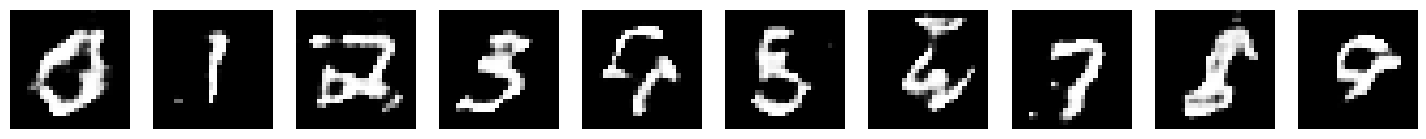



Discriminator evaluation (Real):
          0          8          7          2          4          9          1          6          3          9

    0.296       0.55        0.762       0.38        0.409       0.454       0.491       0.279       0.771       0.583     


C:\Users\christopher_hu\AppData\Local\Temp\ipykernel_7684\133614343.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("  {0:<10}".format(int(value * 1000) / 1000), end = "")


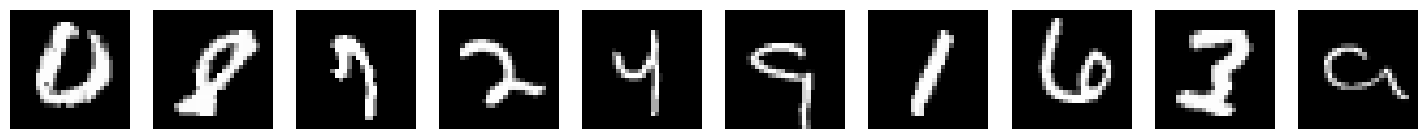

100%|██████████| 1875/1875 [00:45<00:00, 41.53it/s]



Time for epoch 2 is 45.271825551986694 sec
Generator loss: 1.141, Discriminator loss: 0.589
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.224      0.406      0.332      0.207      0.311      0.496      0.318      0.576      0.532      0.5        


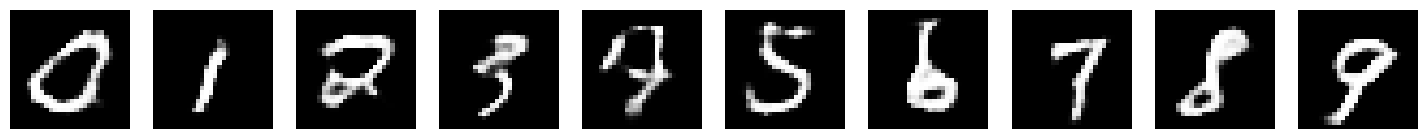



Discriminator evaluation (Real):
          8          8          2          1          7          6          8          6          5          0

    0.414       0.318       0.528       0.461       0.654       0.685       0.635       0.237       0.369       0.603     


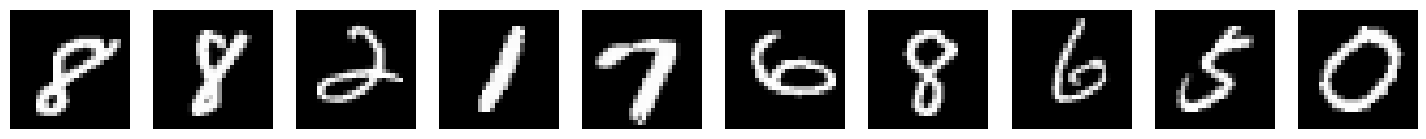

100%|██████████| 1875/1875 [00:45<00:00, 41.07it/s]




Time for epoch 3 is 45.792832136154175 sec
Generator loss: 1.061, Discriminator loss: 0.621
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.349      0.445      0.374      0.24       0.427      0.407      0.389      0.365      0.698      0.608      


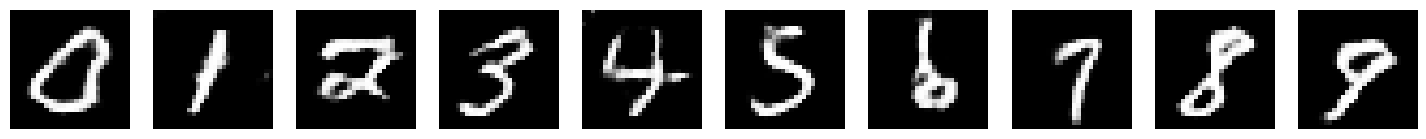



Discriminator evaluation (Real):
          2          7          0          5          1          7          6          1          3          1

    0.331       0.373       0.548       0.431       0.329       0.69        0.385       0.534       0.237       0.706     


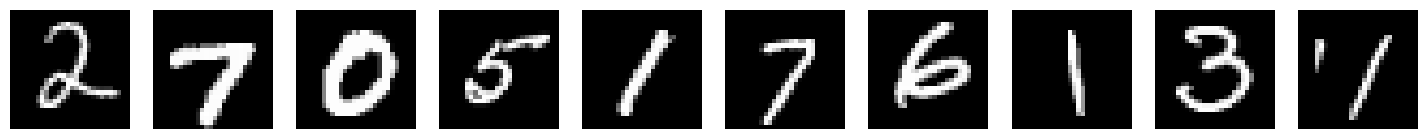

100%|██████████| 1875/1875 [00:45<00:00, 40.99it/s]




Time for epoch 4 is 45.88643550872803 sec
Generator loss: 1.014, Discriminator loss: 0.638
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.339      0.449      0.495      0.491      0.385      0.434      0.339      0.55       0.627      0.651      


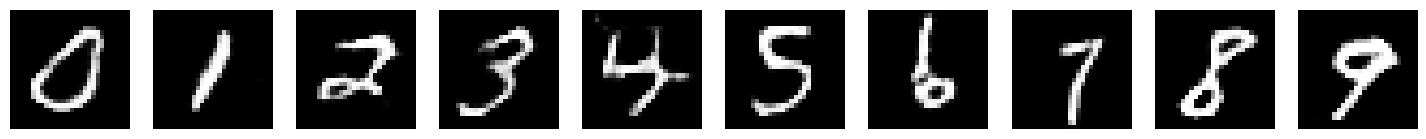



Discriminator evaluation (Real):
          1          5          2          3          7          9          3          3          5          6

    0.438       0.42        0.476       0.55        0.715       0.463       0.579       0.257       0.256       0.321     


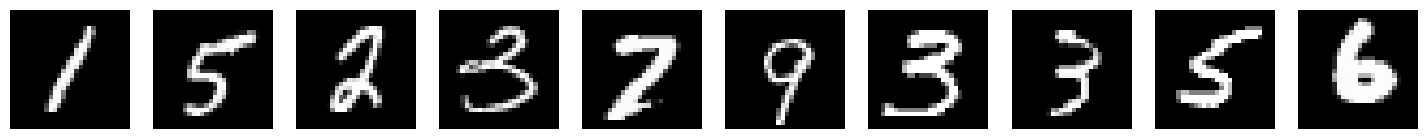

100%|██████████| 1875/1875 [00:45<00:00, 41.19it/s]




Time for epoch 5 is 45.68416476249695 sec
Generator loss: 1.000, Discriminator loss: 0.640
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.508      0.352      0.425      0.398      0.488      0.251      0.608      0.488      0.271      0.627      


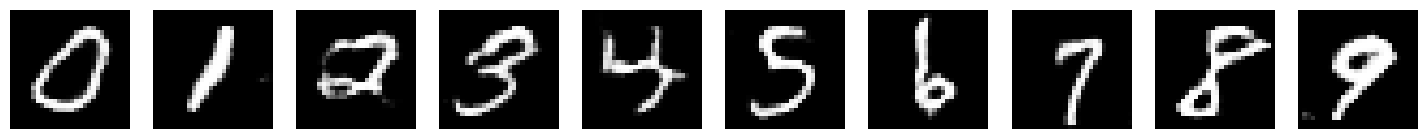



Discriminator evaluation (Real):
          1          1          0          3          4          2          5          1          7          0

    0.562       0.31        0.648       0.575       0.473       0.554       0.686       0.542       0.591       0.433     


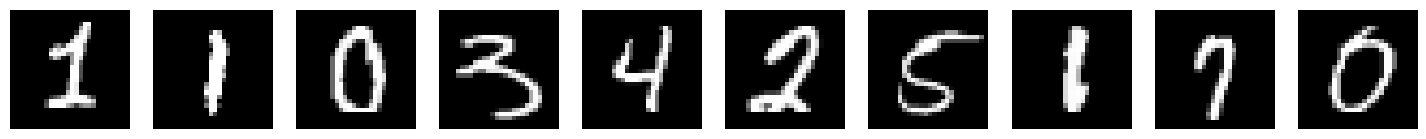

100%|██████████| 1875/1875 [00:44<00:00, 41.72it/s]



Time for epoch 6 is 45.066742181777954 sec
Generator loss: 1.006, Discriminator loss: 0.637
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.403      0.569      0.476      0.663      0.303      0.532      0.686      0.234      0.506      0.545      


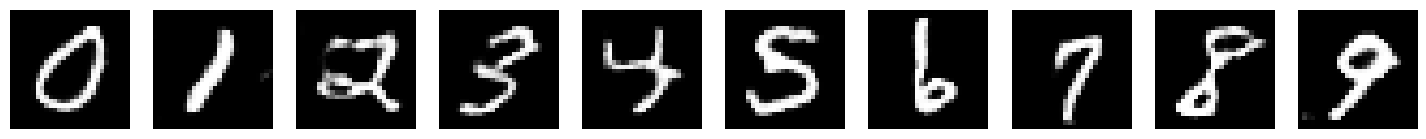



Discriminator evaluation (Real):
          3          2          3          7          2          1          3          4          8          4

    0.53        0.777       0.73        0.51        0.458       0.437       0.618       0.497       0.723       0.544     


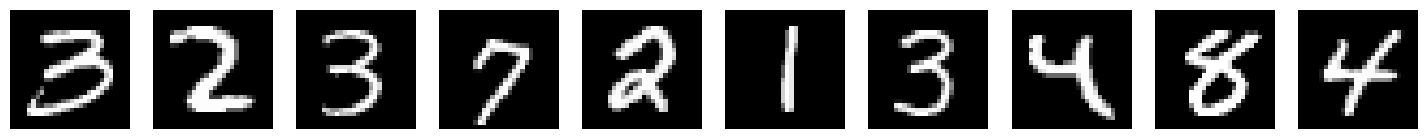

100%|██████████| 1875/1875 [00:44<00:00, 41.91it/s]



Time for epoch 7 is 44.86033606529236 sec
Generator loss: 1.019, Discriminator loss: 0.636
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.404      0.54       0.398      0.398      0.3        0.598      0.583      0.431      0.303      0.404      


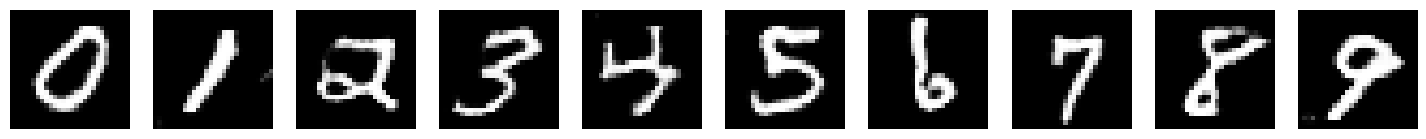



Discriminator evaluation (Real):
          1          2          6          6          5          3          5          6          8          7

    0.281       0.412       0.335       0.262       0.378       0.438       0.342       0.569       0.448       0.362     


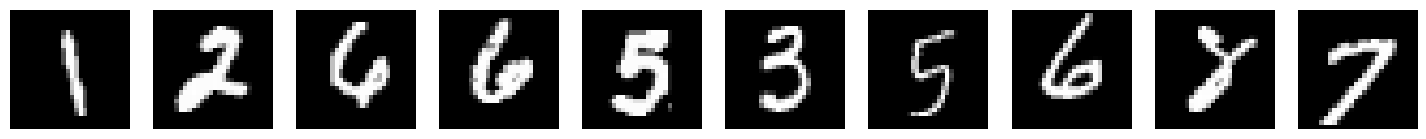

100%|██████████| 1875/1875 [00:44<00:00, 41.95it/s]



Time for epoch 8 is 44.831260442733765 sec
Generator loss: 1.037, Discriminator loss: 0.630
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.508      0.406      0.708      0.62       0.566      0.406      0.582      0.403      0.346      0.529      


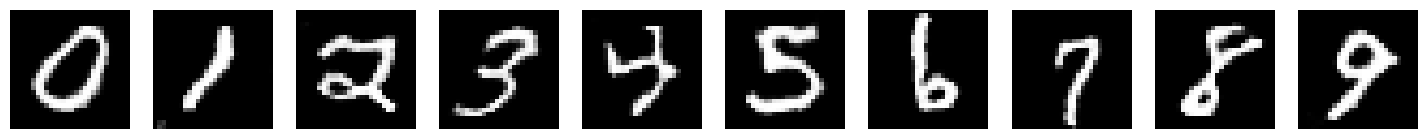



Discriminator evaluation (Real):
          5          9          3          9          6          8          4          5          0          7

    0.592       0.489       0.498       0.661       0.372       0.308       0.41        0.701       0.506       0.404     


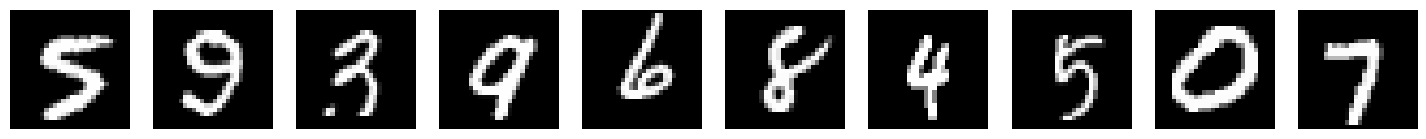

100%|██████████| 1875/1875 [00:45<00:00, 41.65it/s]



Time for epoch 9 is 45.14857864379883 sec
Generator loss: 1.058, Discriminator loss: 0.624
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.315      0.369      0.508      0.359      0.138      0.442      0.356      0.435      0.417      0.337      


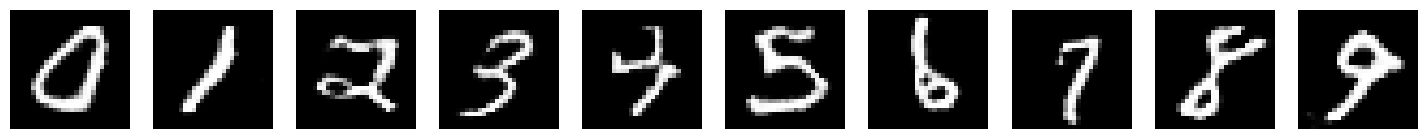



Discriminator evaluation (Real):
          0          3          5          3          6          9          3          4          4          3

    0.646       0.47        0.651       0.683       0.771       0.479       0.326       0.604       0.344       0.724     


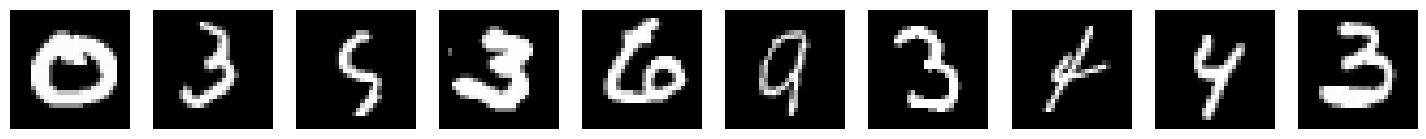

100%|██████████| 1875/1875 [00:45<00:00, 41.59it/s]



Time for epoch 10 is 45.233821630477905 sec
Generator loss: 1.076, Discriminator loss: 0.619
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.546      0.508      0.534      0.475      0.656      0.216      0.544      0.326      0.696      0.3        


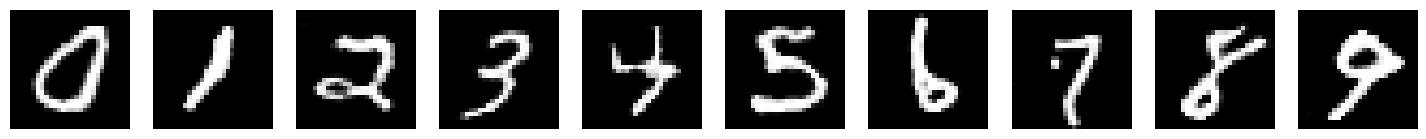



Discriminator evaluation (Real):
          9          3          7          2          5          8          4          6          4          0

    0.559       0.515       0.373       0.585       0.459       0.471       0.689       0.644       0.752       0.621     


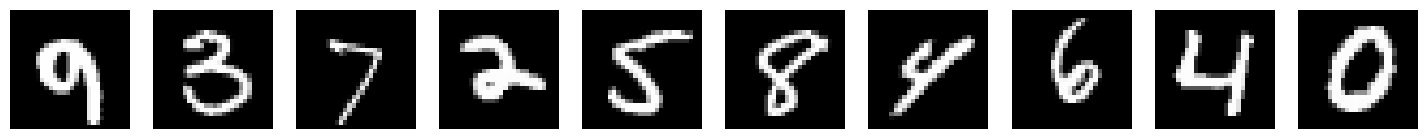

100%|██████████| 1875/1875 [00:45<00:00, 41.22it/s]




Time for epoch 11 is 45.6982102394104 sec
Generator loss: 1.090, Discriminator loss: 0.615
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.591      0.451      0.411      0.229      0.56       0.552      0.497      0.442      0.323      0.622      


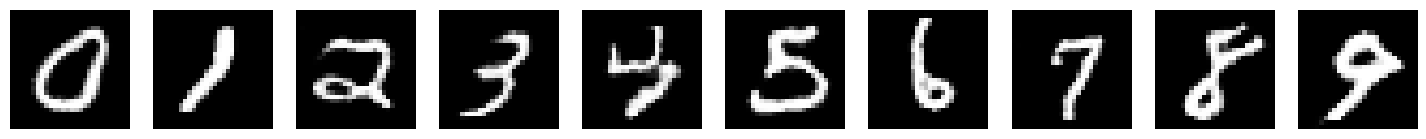



Discriminator evaluation (Real):
          2          6          3          4          4          4          1          4          3          5

    0.776       0.764       0.632       0.71        0.772       0.61        0.674       0.624       0.546       0.396     


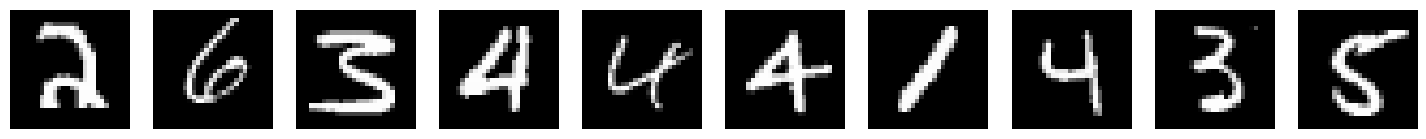

100%|██████████| 1875/1875 [00:47<00:00, 39.42it/s]




Time for epoch 12 is 47.779317140579224 sec
Generator loss: 1.098, Discriminator loss: 0.616
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.369      0.624      0.327      0.301      0.336      0.53       0.299      0.584      0.325      0.523      


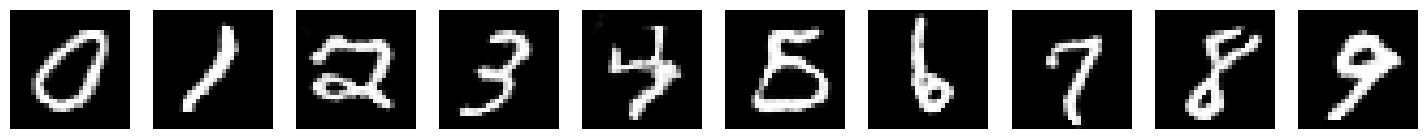



Discriminator evaluation (Real):
          9          0          2          1          0          9          8          3          3          8

    0.648       0.352       0.688       0.612       0.688       0.615       0.486       0.563       0.7         0.333     


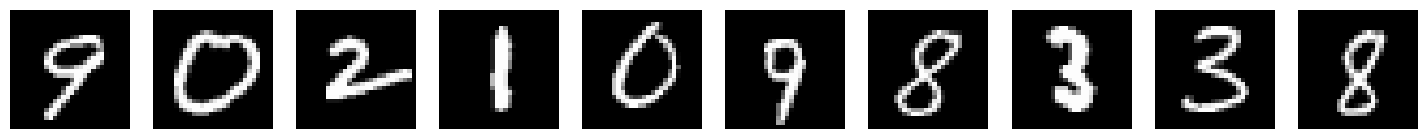

100%|██████████| 1875/1875 [00:47<00:00, 39.49it/s]




Time for epoch 13 is 47.6839554309845 sec
Generator loss: 1.090, Discriminator loss: 0.620
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.228      0.42       0.351      0.227      0.386      0.278      0.248      0.184      0.488      0.542      


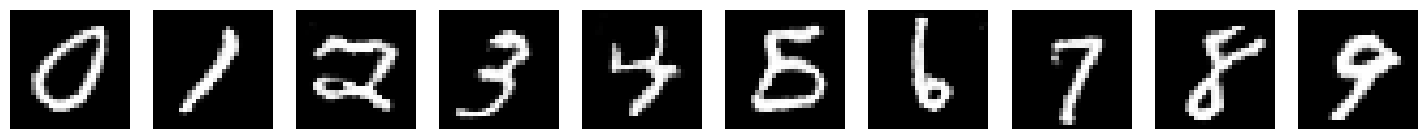



Discriminator evaluation (Real):
          6          0          2          1          5          8          5          9          9          8

    0.516       0.727       0.431       0.295       0.419       0.726       0.428       0.343       0.501       0.779     


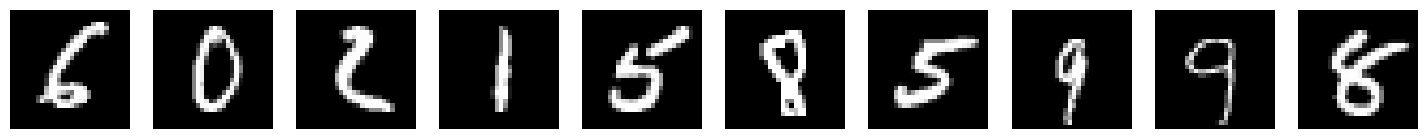

100%|██████████| 1875/1875 [00:46<00:00, 40.00it/s]




Time for epoch 14 is 47.087634563446045 sec
Generator loss: 1.081, Discriminator loss: 0.623
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.356      0.401      0.357      0.536      0.187      0.182      0.114      0.27       0.434      0.246      


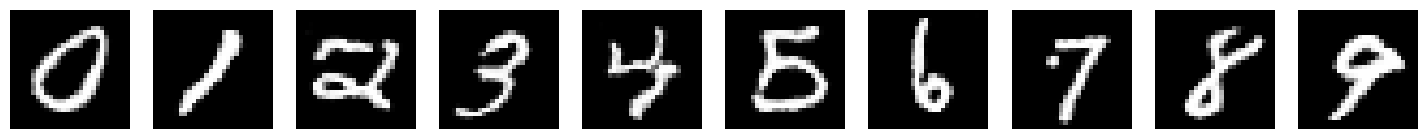



Discriminator evaluation (Real):
          3          2          6          9          7          4          9          5          1          6

    0.36        0.243       0.306       0.333       0.427       0.198       0.245       0.483       0.3         0.397     


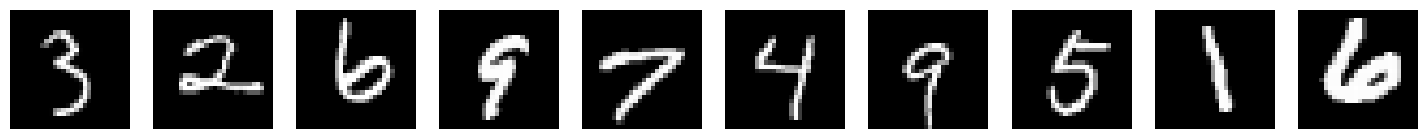

100%|██████████| 1875/1875 [00:45<00:00, 40.86it/s]



Time for epoch 15 is 46.040677309036255 sec
Generator loss: 1.068, Discriminator loss: 0.628
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.443      0.333      0.469      0.383      0.604      0.277      0.516      0.572      0.469      0.579      


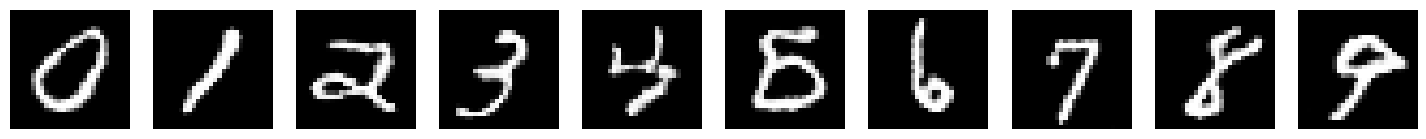



Discriminator evaluation (Real):
          2          9          2          8          3          0          4          2          3          2

    0.398       0.58        0.274       0.64        0.545       0.773       0.566       0.637       0.681       0.513     


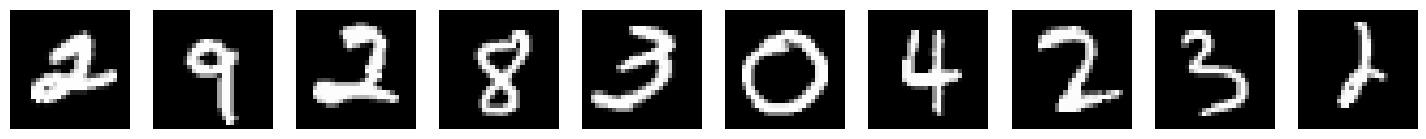

100%|██████████| 1875/1875 [00:44<00:00, 41.71it/s]




Time for epoch 16 is 45.078176736831665 sec
Generator loss: 1.060, Discriminator loss: 0.631
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.591      0.382      0.361      0.554      0.287      0.581      0.489      0.689      0.405      0.65       


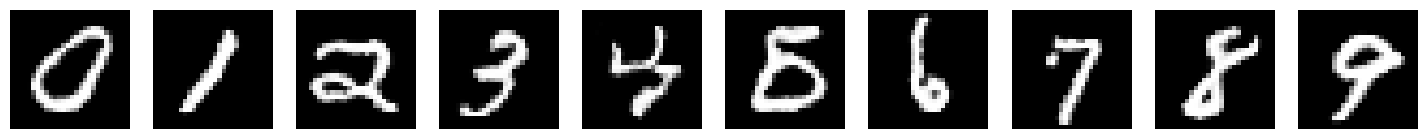



Discriminator evaluation (Real):
          4          9          1          6          5          2          9          6          2          1

    0.705       0.483       0.69        0.836       0.512       0.671       0.522       0.606       0.764       0.517     


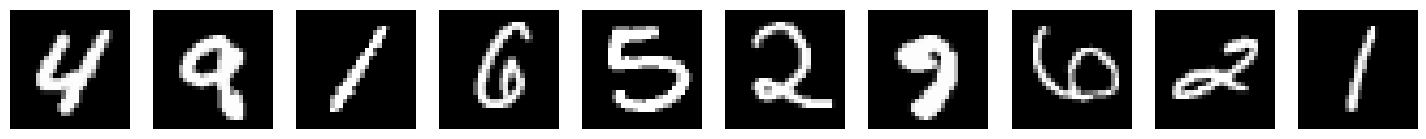

100%|██████████| 1875/1875 [00:45<00:00, 41.66it/s]



Time for epoch 17 is 45.12425661087036 sec
Generator loss: 1.058, Discriminator loss: 0.633
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.289      0.324      0.426      0.536      0.143      0.498      0.162      0.473      0.445      0.358      


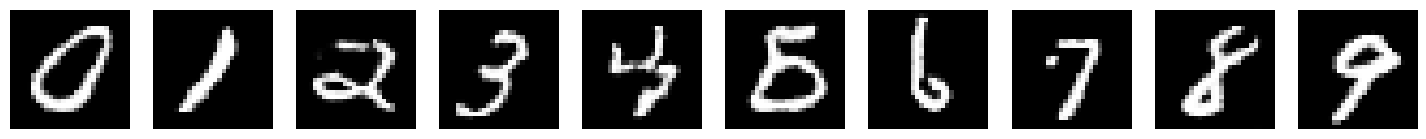



Discriminator evaluation (Real):
          2          2          0          8          0          1          8          4          1          9

    0.427       0.818       0.529       0.322       0.373       0.513       0.313       0.334       0.301       0.442     


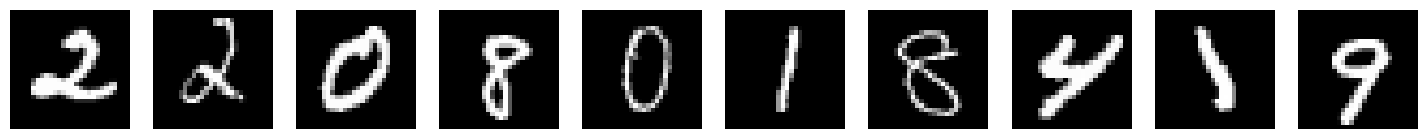

100%|██████████| 1875/1875 [00:45<00:00, 41.62it/s]




Time for epoch 18 is 45.168209075927734 sec
Generator loss: 1.051, Discriminator loss: 0.635
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.393      0.422      0.305      0.336      0.093      0.34       0.29       0.338      0.518      0.283      


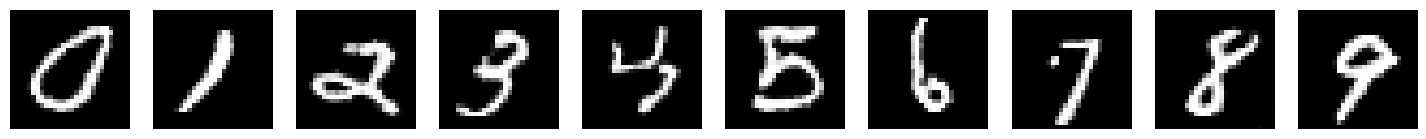



Discriminator evaluation (Real):
          9          6          1          5          0          3          8          5          7          8

    0.498       0.511       0.412       0.424       0.513       0.428       0.475       0.111       0.498       0.142     


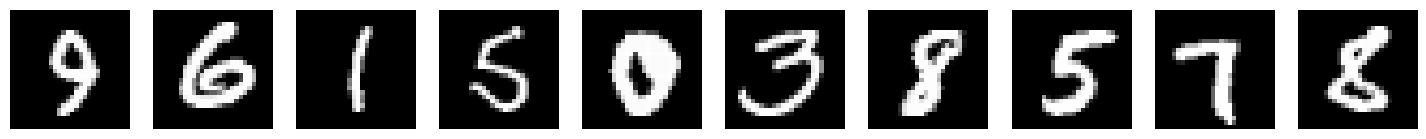

100%|██████████| 1875/1875 [00:44<00:00, 41.71it/s]



Time for epoch 19 is 45.080283403396606 sec
Generator loss: 1.044, Discriminator loss: 0.637
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.579      0.491      0.829      0.219      0.341      0.251      0.314      0.256      0.465      0.269      


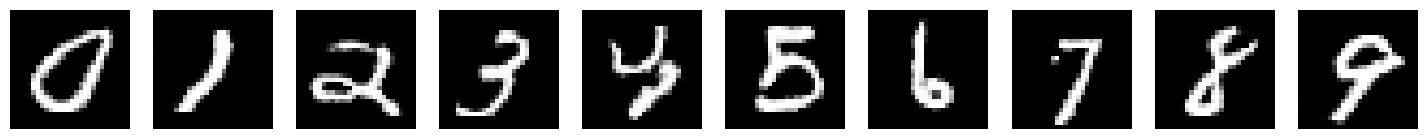



Discriminator evaluation (Real):
          8          6          0          6          1          6          8          5          3          2

    0.57        0.642       0.492       0.214       0.4         0.68        0.56        0.363       0.596       0.59      


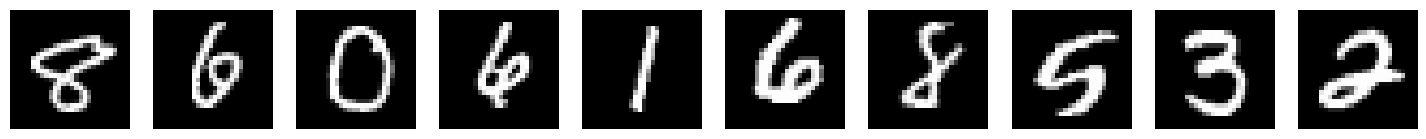

100%|██████████| 1875/1875 [00:44<00:00, 41.76it/s]




Time for epoch 20 is 45.0390830039978 sec
Generator loss: 1.039, Discriminator loss: 0.638
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.499      0.47       0.271      0.14       0.28       0.704      0.544      0.213      0.159      0.219      


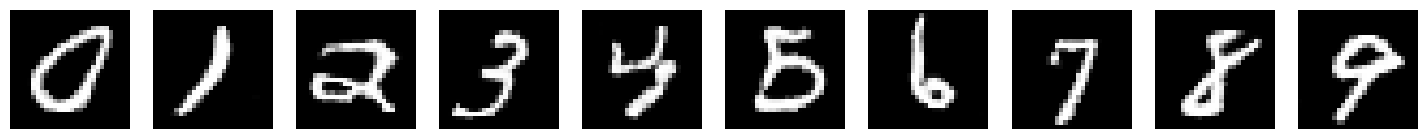



Discriminator evaluation (Real):
          6          5          8          1          2          3          4          7          3          6

    0.313       0.508       0.385       0.398       0.256       0.13        0.402       0.297       0.339       0.357     


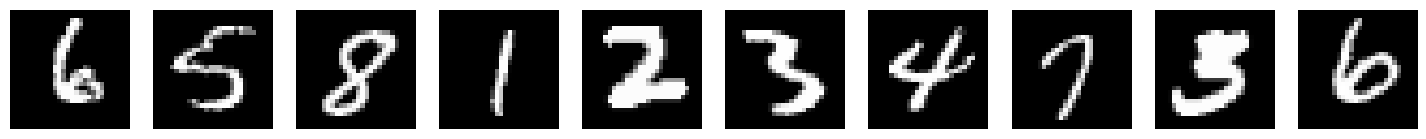

100%|██████████| 1875/1875 [00:45<00:00, 41.40it/s]



Time for epoch 21 is 45.40873575210571 sec
Generator loss: 1.036, Discriminator loss: 0.639
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.228      0.42       0.563      0.334      0.322      0.601      0.289      0.605      0.652      0.523      


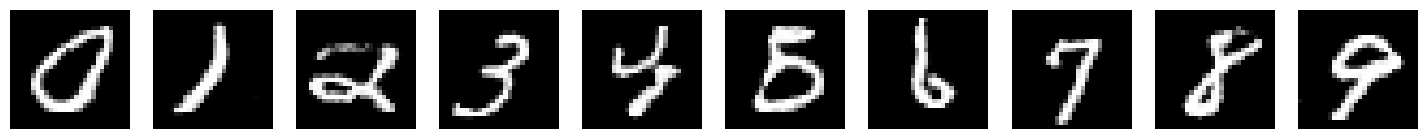



Discriminator evaluation (Real):
          9          4          1          5          1          7          4          2          4          1

    0.577       0.512       0.662       0.631       0.332       0.708       0.64        0.431       0.528       0.454     


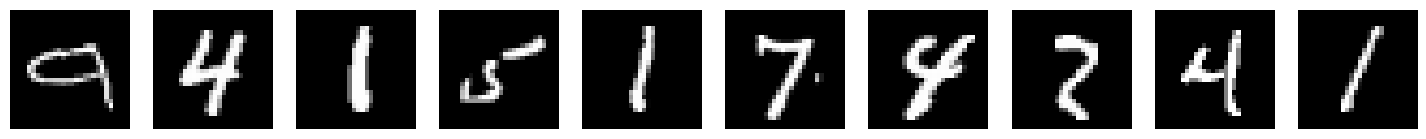

100%|██████████| 1875/1875 [00:45<00:00, 41.55it/s]




Time for epoch 22 is 45.252432346343994 sec
Generator loss: 1.042, Discriminator loss: 0.638
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.584      0.461      0.515      0.595      0.202      0.415      0.295      0.431      0.361      0.617      


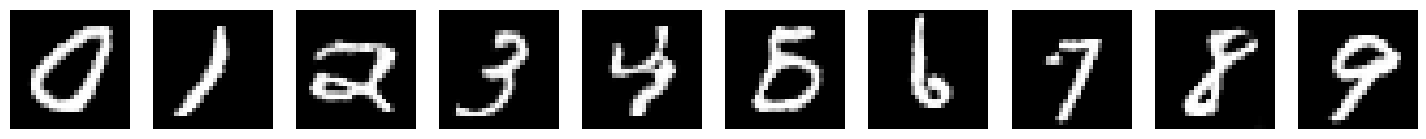



Discriminator evaluation (Real):
          2          5          2          1          9          6          0          9          7          7

    0.427       0.213       0.388       0.456       0.459       0.305       0.54        0.866       0.362       0.496     


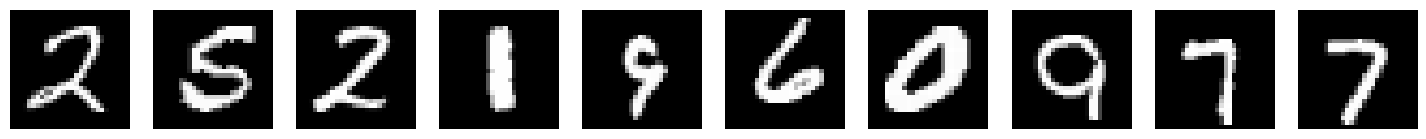

100%|██████████| 1875/1875 [00:44<00:00, 41.76it/s]



Time for epoch 23 is 45.019856452941895 sec
Generator loss: 1.037, Discriminator loss: 0.639
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.589      0.392      0.289      0.176      0.299      0.525      0.41       0.638      0.604      0.396      


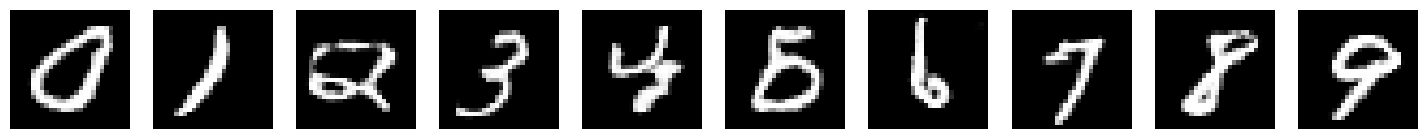



Discriminator evaluation (Real):
          9          4          0          7          6          5          0          1          9          6

    0.448       0.724       0.63        0.428       0.658       0.452       0.576       0.538       0.45        0.55      


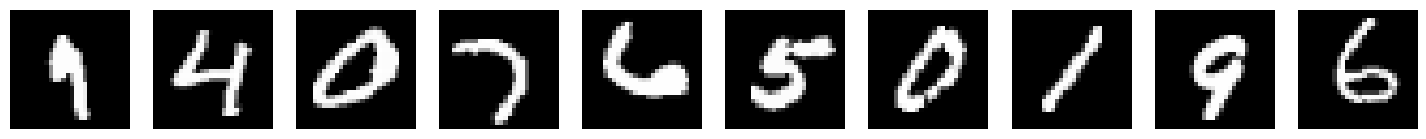

100%|██████████| 1875/1875 [00:44<00:00, 41.69it/s]




Time for epoch 24 is 45.1053102016449 sec
Generator loss: 1.035, Discriminator loss: 0.639
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.609      0.514      0.687      0.177      0.345      0.356      0.375      0.531      0.488      0.482      


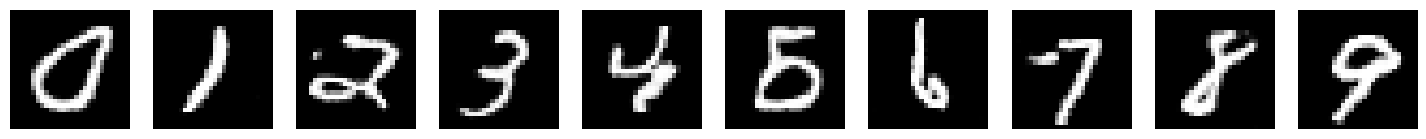



Discriminator evaluation (Real):
          7          6          9          9          8          7          4          1          7          2

    0.386       0.39        0.592       0.405       0.605       0.406       0.484       0.432       0.516       0.544     


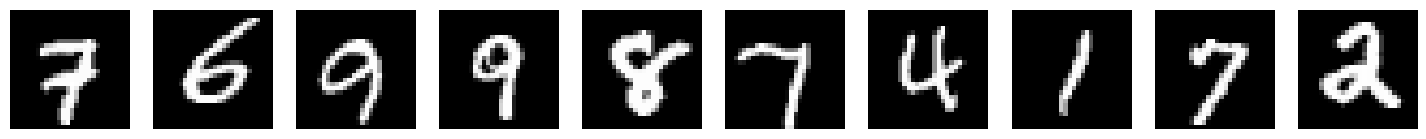

100%|██████████| 1875/1875 [00:44<00:00, 41.71it/s]



Time for epoch 25 is 45.097235679626465 sec
Generator loss: 1.041, Discriminator loss: 0.639
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.553      0.127      0.18       0.145      0.367      0.266      0.344      0.36       0.301      0.409      


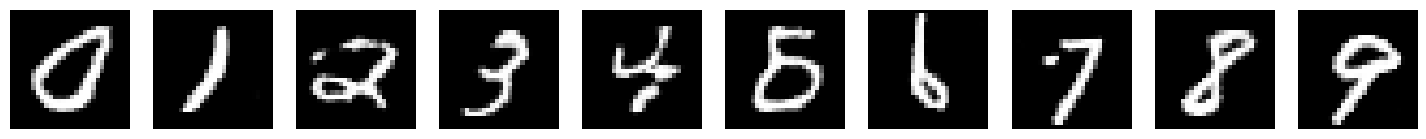



Discriminator evaluation (Real):
          4          5          5          2          9          7          6          3          2          0

    0.654       0.826       0.52        0.597       0.3         0.585       0.751       0.256       0.423       0.57      


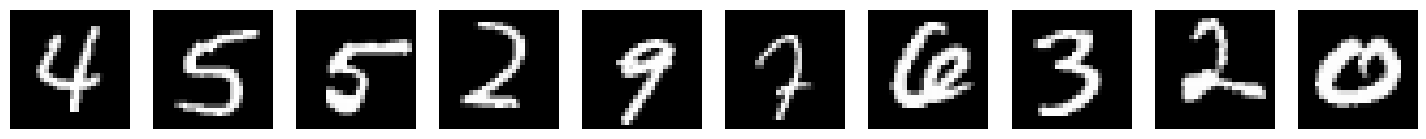

100%|██████████| 1875/1875 [00:45<00:00, 41.60it/s]



Time for epoch 26 is 45.19442129135132 sec
Generator loss: 1.035, Discriminator loss: 0.640
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.472      0.488      0.401      0.239      0.578      0.411      0.385      0.157      0.135      0.631      


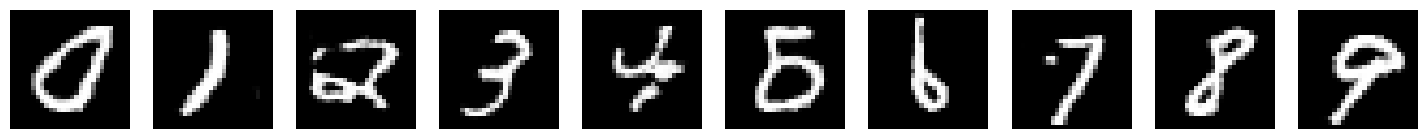



Discriminator evaluation (Real):
          7          0          0          3          4          7          5          1          9          2

    0.256       0.296       0.441       0.363       0.504       0.558       0.357       0.393       0.687       0.696     


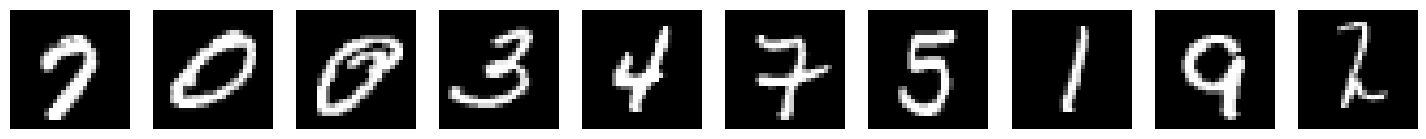

100%|██████████| 1875/1875 [00:44<00:00, 41.69it/s]



Time for epoch 27 is 45.105286836624146 sec
Generator loss: 1.039, Discriminator loss: 0.639
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.572      0.387      0.718      0.412      0.157      0.183      0.33       0.409      0.29       0.553      


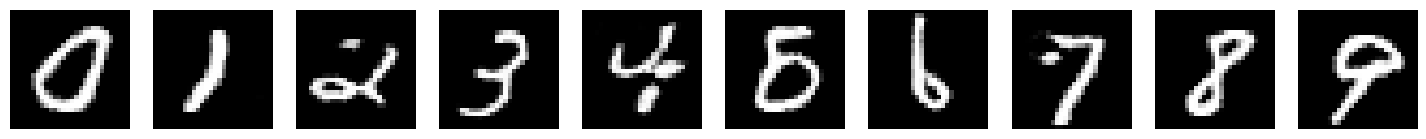



Discriminator evaluation (Real):
          7          2          7          2          1          5          8          4          4          5

    0.474       0.648       0.522       0.303       0.398       0.376       0.376       0.304       0.33        0.332     


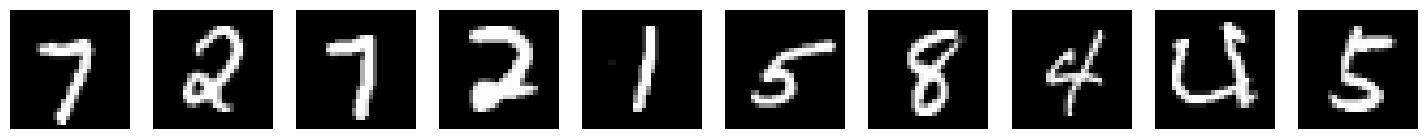

100%|██████████| 1875/1875 [00:44<00:00, 41.67it/s]



Time for epoch 28 is 45.11091923713684 sec
Generator loss: 1.035, Discriminator loss: 0.641
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.538      0.474      0.335      0.201      0.262      0.31       0.137      0.274      0.359      0.278      


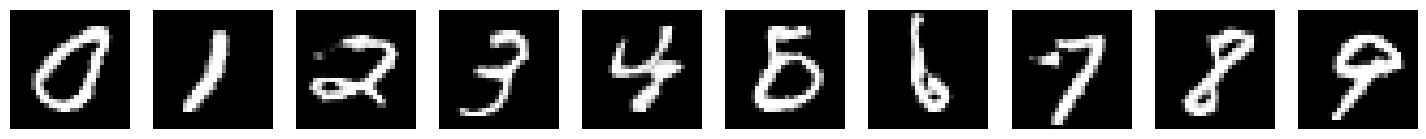



Discriminator evaluation (Real):
          6          6          9          0          0          3          3          1          7          6

    0.096       0.531       0.386       0.473       0.446       0.559       0.535       0.177       0.547       0.527     


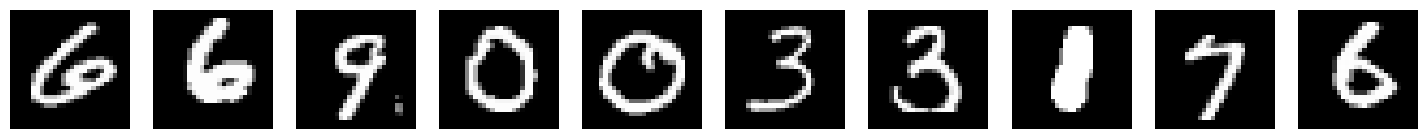

100%|██████████| 1875/1875 [00:44<00:00, 41.73it/s]




Time for epoch 29 is 45.046761989593506 sec
Generator loss: 1.032, Discriminator loss: 0.640
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.34       0.493      0.514      0.447      0.241      0.495      0.575      0.664      0.391      0.731      


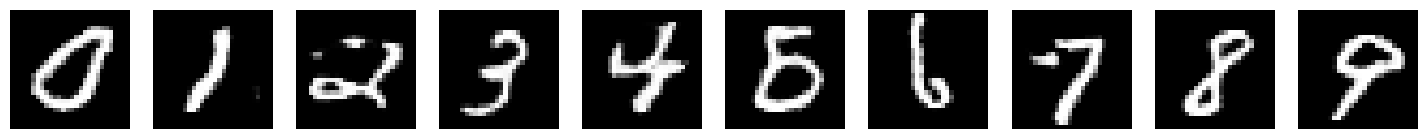



Discriminator evaluation (Real):
          1          4          6          1          4          9          2          1          0          8

    0.607       0.336       0.654       0.557       0.474       0.397       0.558       0.489       0.658       0.447     


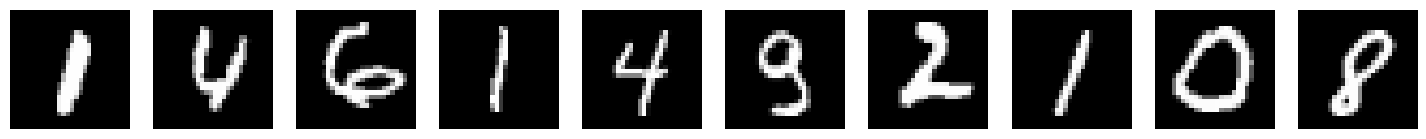

100%|██████████| 1875/1875 [00:44<00:00, 41.79it/s]



Time for epoch 30 is 44.99772548675537 sec
Generator loss: 1.036, Discriminator loss: 0.640
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.507      0.396      0.409      0.333      0.36       0.322      0.495      0.455      0.262      0.686      


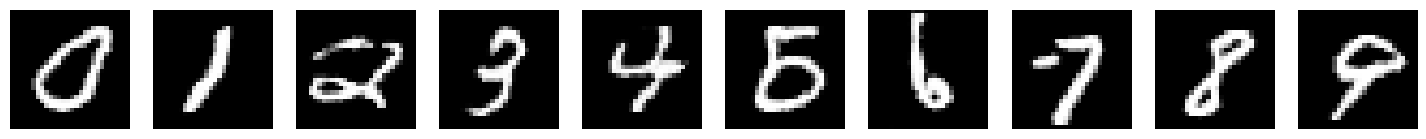



Discriminator evaluation (Real):
          2          7          3          4          9          2          8          1          2          2

    0.434       0.478       0.768       0.512       0.566       0.502       0.685       0.44        0.423       0.72      


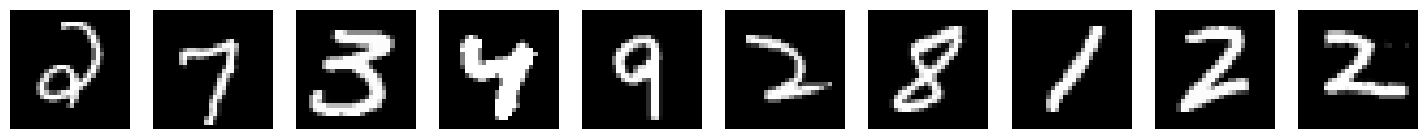

100%|██████████| 1875/1875 [00:44<00:00, 41.68it/s]




Time for epoch 31 is 45.11382603645325 sec
Generator loss: 1.035, Discriminator loss: 0.640
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.332      0.595      0.351      0.253      0.175      0.534      0.503      0.665      0.206      0.464      


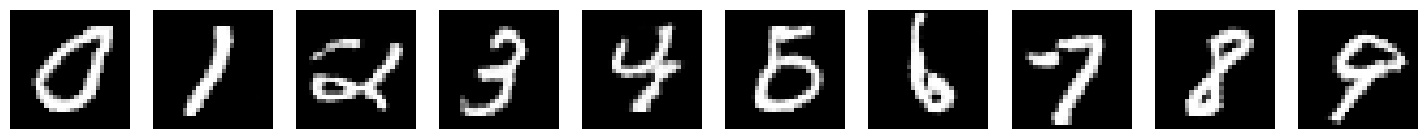



Discriminator evaluation (Real):
          1          9          8          7          3          8          1          8          0          6

    0.456       0.371       0.387       0.599       0.367       0.436       0.415       0.42        0.57        0.455     


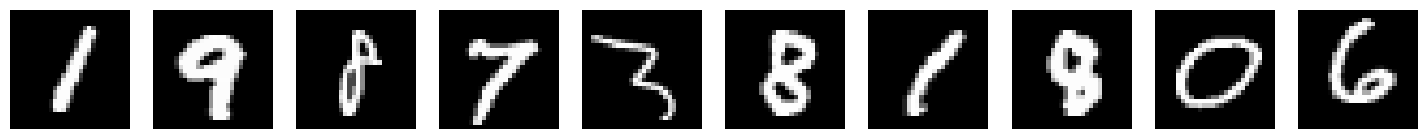

100%|██████████| 1875/1875 [00:45<00:00, 41.22it/s]



Time for epoch 32 is 45.61442947387695 sec
Generator loss: 1.028, Discriminator loss: 0.643
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.349      0.439      0.572      0.537      0.309      0.426      0.277      0.256      0.338      0.507      


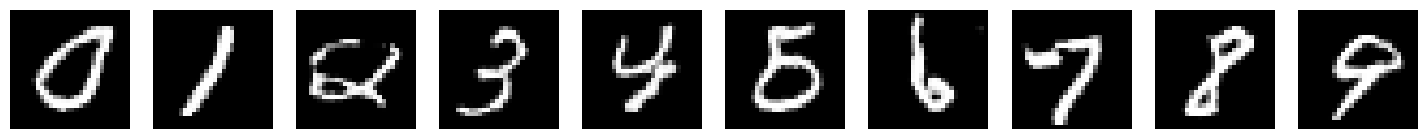



Discriminator evaluation (Real):
          4          9          6          1          1          1          3          3          4          2

    0.668       0.692       0.7         0.525       0.525       0.653       0.313       0.55        0.557       0.431     


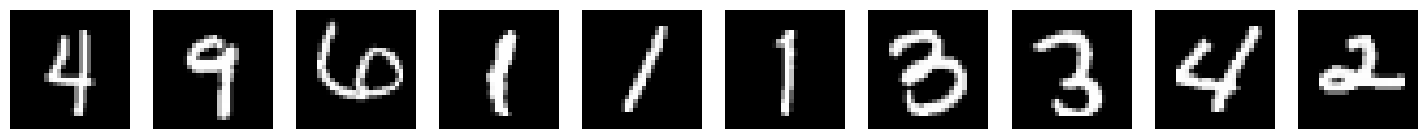

100%|██████████| 1875/1875 [00:46<00:00, 40.65it/s]




Time for epoch 33 is 46.3516321182251 sec
Generator loss: 1.031, Discriminator loss: 0.642
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.39       0.612      0.375      0.402      0.139      0.327      0.295      0.647      0.277      0.375      


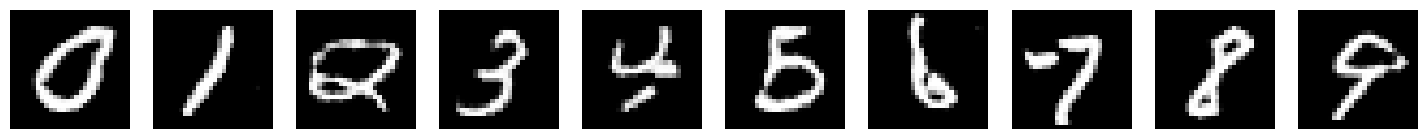



Discriminator evaluation (Real):
          1          2          4          2          1          3          9          0          5          3

    0.655       0.4         0.439       0.303       0.504       0.353       0.463       0.525       0.441       0.435     


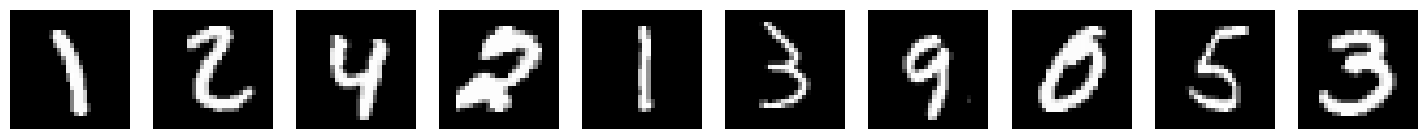

100%|██████████| 1875/1875 [00:47<00:00, 39.21it/s]




Time for epoch 34 is 48.03613209724426 sec
Generator loss: 1.029, Discriminator loss: 0.642
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.643      0.45       0.304      0.298      0.443      0.386      0.256      0.365      0.332      0.364      


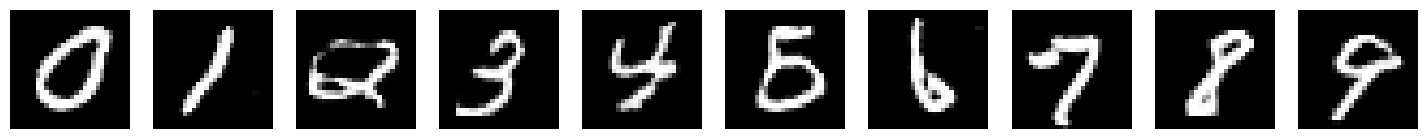



Discriminator evaluation (Real):
          1          8          8          9          6          4          0          3          4          8

    0.616       0.695       0.56        0.657       0.665       0.189       0.387       0.628       0.821       0.666     


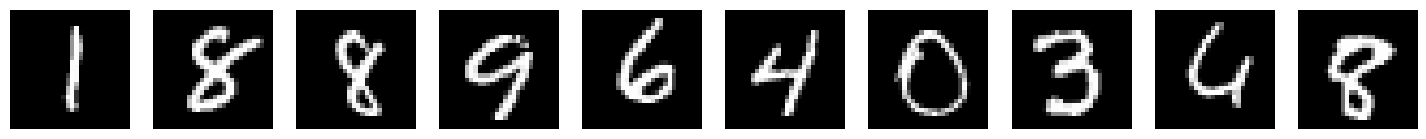

100%|██████████| 1875/1875 [00:47<00:00, 39.15it/s]




Time for epoch 35 is 48.131967544555664 sec
Generator loss: 1.030, Discriminator loss: 0.642
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.349      0.292      0.637      0.215      0.207      0.433      0.215      0.411      0.309      0.497      


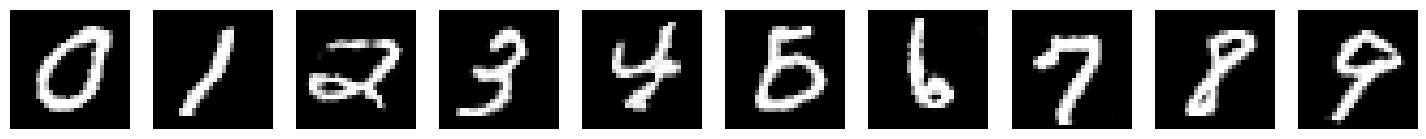



Discriminator evaluation (Real):
          4          0          2          8          3          3          4          8          9          6

    0.586       0.486       0.385       0.272       0.414       0.686       0.456       0.648       0.488       0.438     


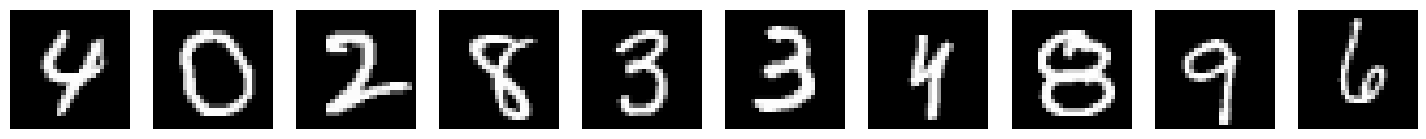

100%|██████████| 1875/1875 [00:47<00:00, 39.62it/s]




Time for epoch 36 is 47.53506779670715 sec
Generator loss: 1.032, Discriminator loss: 0.643
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.651      0.732      0.41       0.326      0.419      0.679      0.324      0.468      0.462      0.611      


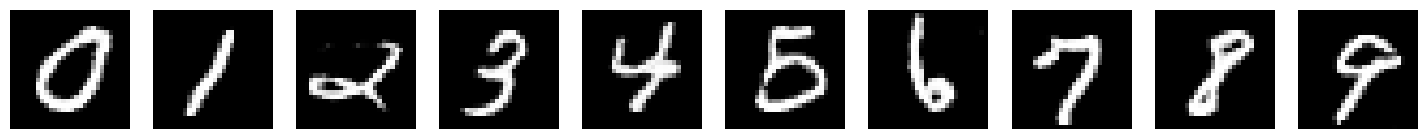



Discriminator evaluation (Real):
          7          8          0          8          8          1          9          5          7          1

    0.585       0.404       0.343       0.676       0.443       0.56        0.453       0.385       0.481       0.347     


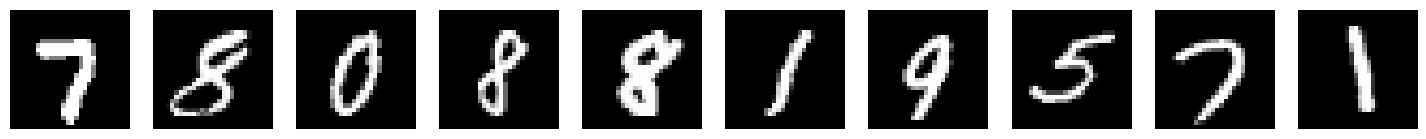

100%|██████████| 1875/1875 [00:46<00:00, 40.01it/s]




Time for epoch 37 is 47.07881212234497 sec
Generator loss: 1.032, Discriminator loss: 0.643
Discriminator evaluation (Fake):
          0          1          2          3          4          5          6          7          8          9

  0.499      0.39       0.19       0.331      0.174      0.239      0.578      0.515      0.616      0.557      


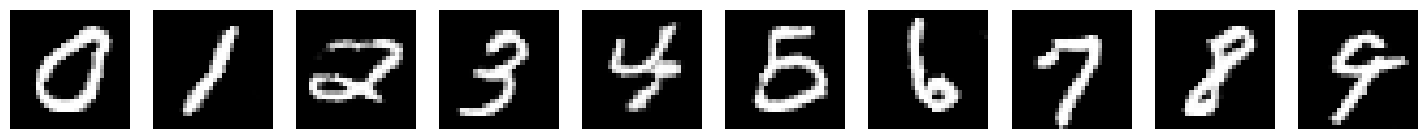



Discriminator evaluation (Real):
          7          2          5          7          9          1          9          4          7          0

    0.376       0.26        0.679       0.521       0.276       0.467       0.301       0.443       0.364       0.465     


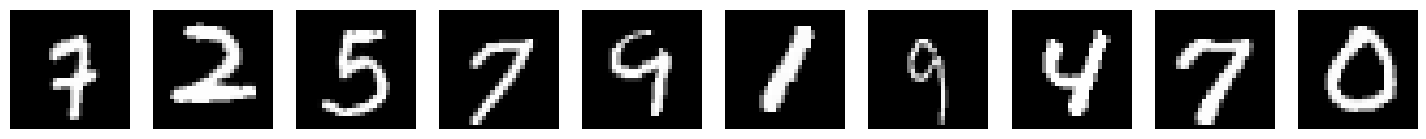

 65%|██████▌   | 1224/1875 [00:39<00:37, 17.59it/s]

In [20]:
train(train_dataloader, epoch_number)

In [ ]:
def plot_result(metrics, ylabel = None, ylim = None, metric_name = None, color = None):
    fig, ax = plt.subplots(figsize = (18, 5))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
    
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color = color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, epoch_number - 1])
    plt.ylim(ylim)

    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   

    plt.show(block = False)
    plt.close()

In [ ]:
plot_result([G_LOSS, D_LOSS],        
    ylabel = 'Loss', 
    ylim = [0,3],
    metric_name = ['Generator Loss', 'Discriminator Loss'],
    color = ['g', 'b']
)

In [ ]:
plot_result([predictions_fake, predictions_real],       
    ylabel = "Discriminator Predictions (average for a single batch)", 
    ylim = [0, 1],
    metric_name = ["Discriminator (Fake Images)", "Discriminator (Real Images)"],
    color = ["g", "b"]
)

In [ ]:
def generate_images(model_g, num_samples = 3):
    plt.figure(figsize = (20, 7))
    k = 0

    x = np.arange(0, num_classes).tolist()
    labels = torch.tensor(x, dtype = torch.int64).to(device)

    for i in range(num_samples):
        noise = torch.randn(
            num_classes, 
            latent_dimension,
        ).to(device)

        images = model_g((noise, labels))

        images = images.cpu().view((images.shape[0]), img_height, img_width)

        for j in range(num_classes):
            image = (images[j, :, :] + 1 ) * 127.5
            image = image.detach().cpu()
            plt.subplot(num_samples, num_classes, k + 1)
            plt.title(label_dict[j])
            plt.imshow(image, cmap = 'gray')
            plt.axis('off') 
            k += 1 

    plt.show()

In [ ]:
trained_generator = torch.load(generator_ckpt)

In [ ]:
generate_images(trained_generator, num_samples = 3)